<p style="text-align:center">
    <a href="https://skills.network" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo"  />
    </a>
</p>


# **Lab: Building Advanced Transformers**

**Estimated time needed: 30 minutes**

In this lab, you will implement and experiment with advanced Transformer models using Keras.

**Learning objectives:**

By the end of this lab, you will be able to:

- Understand the core components of a Transformer architecture.
- Implement a multi-head self-attention mechanism from scratch.
- Train and evaluate a Transformer for time series prediction.
- Handle preprocessing and scaling for time series data effectively.


## What is a Transformer?

The Transformer architecture was introduced in the paper _"Attention Is All You Need"_. It revolutionized natural language processing by using attention mechanisms instead of recurrence.

### Key Components:

- **Input Embedding:** Converts input tokens (or time steps) into vectors.
- **Positional Encoding:** Injects information about the position of input tokens.
- **Multi-Head Self-Attention:** Allows the model to focus on different parts of the input sequence.
- **Feedforward Layers:** Process the attended information.
- **Layer Normalization & Residual Connections:** Stabilize and speed up training.

> Transformers are now widely used not only in NLP but also in time series forecasting, image recognition, and more.

**Next:** You will implement parts of this architecture step-by-step.


## Step-by-Step Instructions:

### Step 1: Import necessary libraries

Before you start, you need to import the required libraries: TensorFlow and Keras. Keras is included within TensorFlow as `tensorflow.keras.`


In [ ]:
%pip install tensorflow pyarrow
%pip install pandas
%pip install scikit-learn
%pip install matplotlib
%pip install requests



In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import requests
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

#### Setup the Environment to generate synthetic stock price data


In [ ]:
import numpy as np
import pandas as pd

# Create a synthetic stock price dataset
np.random.seed(42)
data_length = 2000  # Adjust data length as needed
trend = np.linspace(100, 200, data_length)
noise = np.random.normal(0, 2, data_length)
synthetic_data = trend + noise

# Create a DataFrame and save as 'stock_prices.csv'
data = pd.DataFrame(synthetic_data, columns=['Close'])
data.to_csv('stock_prices.csv', index=False)
print("Synthetic stock_prices.csv created and loaded.")


Synthetic stock_prices.csv created and loaded.


In [ ]:
# Load the dataset
data = pd.read_csv('stock_prices.csv')
data = data[['Close']].values

# Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data = scaler.fit_transform(data)

# Prepare the data for training
def create_dataset(data, time_step=1):
    X, Y = [], []

    for i in range(len(data)-time_step-1):
        a = data[i:(i+time_step), 0]
        X.append(a)
        Y.append(data[i + time_step, 0])
    return np.array(X), np.array(Y)

time_step = 100
X, Y = create_dataset(data, time_step)
X = X.reshape(X.shape[0], X.shape[1], 1)

print("Shape of X:", X.shape)
print("Shape of Y:", Y.shape)

Shape of X: (1899, 100, 1)
Shape of Y: (1899,)


In the above code:

`tensorflow` is the main library for machine learning in Python.

`stock_prices.csv` is the data set that is loaded.

`MinMaxScaler` method is used to normalize the data.

`create_dataset`method is used to prepare the data for training.


### Step 2: Implement Multi-Head Self-Attention

Define the Multi-Head Self-Attention mechanism.


In [ ]:
# Define a custom layer for Multi-Head Self-Attention mechanism
class MultiHeadSelfAttention(Layer):

    def __init__(self, embed_dim, num_heads=8):
        # Initialize the layer with embedding dimension and number of attention heads
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim  # Total embedding dimension
        self.num_heads = num_heads  # Number of attention heads
        self.projection_dim = embed_dim // num_heads  # Dimension of each attention head
        # Dense layers for transforming input into query, key and value
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim) 
        self.value_dense = Dense(embed_dim)
        # Dense layer to combine outputs of attention heads
        self.combine_heads = Dense(embed_dim)

    def attention(self, query, key, value):
        # Compute attention scores between query and key
        score = tf.matmul(query, key, transpose_b=True)
        # Get dimension of key for scaling
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        # Scale dot product to prevent exploding gradients
        scaled_score = score / tf.math.sqrt(dim_key)
        # Apply softmax to get attention weights
        weights = tf.nn.softmax(scaled_score, axis=-1)
        # Compute weighted sum of values
        output = tf.matmul(weights, value)
        return output, weights

    def split_heads(self, x, batch_size):
        # Reshape input to separate heads
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        # Transpose to get shape [batch_size, num_heads, seq_length, projection_dim]
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # Get batch size from input shape
        batch_size = tf.shape(inputs)[0]
        # Create query, key and value projections
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        # Split projections into multiple heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        # Compute scaled dot-product attention
        attention, _ = self.attention(query, key, value)
        # Reshape attention output to original dimensions
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        # Combine heads using dense layer
        output = self.combine_heads(concat_attention)
        return output


In the above code:

- The MultiHeadSelfAttention layer implements the multi-head self-attention mechanism, which allows the model to focus on different parts of the input sequence simultaneously.

- The attention parameter computes the attention scores and weighted sum of the values.

- The split_heads parameter splits the input into multiple heads for parallel attention computation.

- The call method applies the self-attention mechanism and combines the heads.


### Step 3: Implement Transformer block

Define the Transformer block.


In [ ]:
class TransformerBlock(Layer):
    # Initialize the Transformer block with embedding dimension, number of heads, feedforward dimension and dropout rate
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        # Create multi-head self-attention layer
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        
        # Create feedforward network with two dense layers
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),  # First dense layer with ReLU activation
            Dense(embed_dim),                  # Second dense layer projecting back to embed_dim
        ])

        # Create layer normalization layers
        self.layernorm1 = LayerNormalization(epsilon=1e-6)  # For attention output
        self.layernorm2 = LayerNormalization(epsilon=1e-6)  # For feedforward output
        
        # Create dropout layers for regularization
        self.dropout1 = Dropout(rate)  # Dropout after attention
        self.dropout2 = Dropout(rate)  # Dropout after feedforward

    # Forward pass of the transformer block
    def call(self, inputs, training):
        # Apply self-attention mechanism
        attn_output = self.att(inputs)
        
        # Apply dropout to attention output during training
        attn_output = self.dropout1(attn_output, training=training)
        
        # Add residual connection and normalize
        out1 = self.layernorm1(inputs + attn_output)
        
        # Pass through feedforward network
        ffn_output = self.ffn(out1)
        
        # Apply dropout to feedforward output during training
        ffn_output = self.dropout2(ffn_output, training=training)
        
        # Add second residual connection and normalize
        return self.layernorm2(out1 + ffn_output)

In the above code:

- The TransformerBlock layer combines multi-head self-attention with a feed-forward neural network and normalization layers.

- Dropout is used to prevent overfitting.

- The call method applies the self-attention, followed by the feedforward network with residual connections and layer normalization.


### Step 4: Implement Encoder Layer

Define the Encoder layer.


In [ ]:
# Define a custom layer for the Encoder part of the Transformer
class EncoderLayer(Layer):

    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        # Initialize the encoder layer with embedding dimension, number of heads, feedforward dimension and dropout rate
        super(EncoderLayer, self).__init__()
        # Create multi-head self-attention layer
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        # Create feedforward network with two dense layers
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),  # First dense layer with ReLU activation
            Dense(embed_dim),                  # Second dense layer projecting back to embed_dim
        ])

        # Create layer normalization layers
        self.layernorm1 = LayerNormalization(epsilon=1e-6)  # For attention output
        self.layernorm2 = LayerNormalization(epsilon=1e-6)  # For feedforward output
        
        # Create dropout layers for regularization
        self.dropout1 = Dropout(rate)  # Dropout after attention
        self.dropout2 = Dropout(rate)  # Dropout after feedforward

    def call(self, inputs, training):
        # Apply self-attention mechanism to the inputs
        attn_output = self.att(inputs)
        # Apply dropout to attention output during training
        attn_output = self.dropout1(attn_output, training=training)
        # Add residual connection and normalize
        out1 = self.layernorm1(inputs + attn_output)
        # Pass through feedforward network
        ffn_output = self.ffn(out1)
        # Apply dropout to feedforward output during training
        ffn_output = self.dropout2(ffn_output, training=training)
        # Add second residual connection and normalize
        return self.layernorm2(out1 + ffn_output)


In the above code:

- The EncoderLayer is similar to the TransformerBlock but is a reusable layer in the Transformer architecture.

- It consists of a MultiHeadSelfAttention mechanism followed by a feedforward neural network.

- Both sub-layers have residual connections around them, and layer normalization is applied to the output of each sub-layer.

- The call method applies the self-attention, followed by the feedforward network, with residual connections and layer normalization.


### Step 5: Implement Transformer encoder

Define the Transformer Encoder.


In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Layer, Dense, LayerNormalization, Dropout

# Define MultiHeadSelfAttention layer that inherits from the base Layer class
class MultiHeadSelfAttention(Layer):
    # Initialize the layer with embedding dimension and number of attention heads
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        # Set embedding dimension
        self.embed_dim = embed_dim
        # Set number of attention heads
        self.num_heads = num_heads
        # Calculate projection dimension for each head
        self.projection_dim = embed_dim // num_heads
        # Create dense layers for query, key and value transformations
        self.query_dense = Dense(embed_dim)
        self.key_dense = Dense(embed_dim)
        self.value_dense = Dense(embed_dim)
        # Create dense layer to combine attention heads
        self.combine_heads = Dense(embed_dim)

    # Compute attention scores and weighted sum
    def attention(self, query, key, value):
        # Compute dot product between query and key
        score = tf.matmul(query, key, transpose_b=True)
        # Get dimension of key for scaling
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        # Scale dot product to prevent gradient explosion
        scaled_score = score / tf.math.sqrt(dim_key)
        # Apply softmax to get attention weights
        weights = tf.nn.softmax(scaled_score, axis=-1)
        # Compute weighted sum of values
        output = tf.matmul(weights, value)
        return output, weights

    # Split the input tensor into multiple heads
    def split_heads(self, x, batch_size):
        # Reshape input to separate attention heads
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        # Transpose dimensions to get correct shape
        return tf.transpose(x, perm=[0, 2, 1, 3])

    # Forward pass of the attention layer
    def call(self, inputs):
        # Get batch size from input shape
        batch_size = tf.shape(inputs)[0]
        # Create query, key and value projections
        query = self.query_dense(inputs)
        key = self.key_dense(inputs)
        value = self.value_dense(inputs)
        # Split projections into multiple heads
        query = self.split_heads(query, batch_size)
        key = self.split_heads(key, batch_size)
        value = self.split_heads(value, batch_size)
        # Apply attention mechanism
        attention, _ = self.attention(query, key, value)
        # Reshape attention output
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])
        concat_attention = tf.reshape(attention, (batch_size, -1, self.embed_dim))
        # Combine heads
        output = self.combine_heads(concat_attention)
        return output

# Define TransformerBlock layer that combines attention and feedforward network
class TransformerBlock(Layer):
    # Initialize the transformer block
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        # Create multi-head self-attention layer
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        # Create feedforward network
        self.ffn = tf.keras.Sequential([
            Dense(ff_dim, activation="relu"),
            Dense(embed_dim),
        ])
        # Create layer normalization and dropout layers
        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)
        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)

    # Forward pass of the transformer block
    def call(self, inputs, training):
        # Apply attention mechanism
        attn_output = self.att(inputs)
        # Apply dropout to attention output
        attn_output = self.dropout1(attn_output, training=training)
        # Add residual connection and normalize
        out1 = self.layernorm1(inputs + attn_output)
        # Pass through feedforward network
        ffn_output = self.ffn(out1)
        # Apply dropout to feedforward output
        ffn_output = self.dropout2(ffn_output, training=training)
        # Add residual connection and normalize
        return self.layernorm2(out1 + ffn_output)

# Define TransformerEncoder that stacks multiple transformer blocks
class TransformerEncoder(Layer):
    # Initialize the encoder with specified number of layers and dimensions
    def __init__(self, num_layers, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerEncoder, self).__init__()
        # Set number of layers and embedding dimension
        self.num_layers = num_layers
        self.embed_dim = embed_dim
        # Create list of transformer blocks
        self.enc_layers = [TransformerBlock(embed_dim, num_heads, ff_dim, rate) for _ in range(num_layers)]
        # Create dropout layer
        self.dropout = Dropout(rate)

    # Forward pass through all transformer blocks
    def call(self, inputs, training=False):
        # Pass input through each transformer block sequentially
        x = inputs
        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training=training)
        return x

# Example usage
embed_dim = 128
num_heads = 8
ff_dim = 512
num_layers = 4

transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim)
inputs = tf.random.uniform((1, 100, embed_dim))
outputs = transformer_encoder(inputs, training=False)  # Use keyword argument for 'training'
print(outputs.shape)  # Should print (1, 100, 128)

(1, 100, 128)


In the above code:

The TransformerEncoder is composed of multiple TransformerBlock layers, implementing the encoding part of the Transformer architecture.


### Step 6: Build and Compile the Transformer model

Integrate the Transformer Encoder into a complete model for sequential data.


In [ ]:
# Define the necessary parameters

embed_dim = 128
num_heads = 8
ff_dim = 512
num_layers = 4

# Define the Transformer Encoder
transformer_encoder = TransformerEncoder(num_layers, embed_dim, num_heads, ff_dim)

# Build the model
input_shape = (X.shape[1], X.shape[2])
inputs = tf.keras.Input(shape=input_shape)

# Project the inputs to the embed_dim
x = tf.keras.layers.Dense(embed_dim)(inputs)
encoder_outputs = transformer_encoder(x)
flatten = tf.keras.layers.Flatten()(encoder_outputs)
outputs = tf.keras.layers.Dense(1)(flatten)
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Summary of the model
model.summary()


Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 100, 1)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_48 (Dense)                │ (None, 100, 128)       │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ transformer_encoder_1           │ (None, 100, 128)       │       793,088 │
│ (TransformerEncoder)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_49 (Dense)                │ (None, 1)              │        12,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 806,145 (3.08 MB)

 Trainable params: 806,145 (3.08 MB)

 Non-trainable params: 0 (0.00 B)

In the above code:

- The Transformer Encoder model defines the necessary parameters, flattens the output, and ends with a dense layer to produce the final output.

- The model is then compiled with the Adam optimizer and mean squared error loss.


### Step 7: Train the Transformer model

Train the model on the prepared dataset.


In [ ]:
# Train the model
model.fit(X, Y, epochs=20, batch_size=32)


Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 33s 162ms/step - loss: 16.4223
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.2313
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1937
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.1565
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.2172
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1349
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1311
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1431
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1718
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1079
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.1288
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - loss: 0.1060
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.1401
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0866
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0708
E

In the above code:

The model is trained on the normalized stock price data for 20 epochs with a batch size of 32.


### Step 8: Evaluate and Make Predictions

Evaluate the model's performance and make predictions on the dataset.


60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step


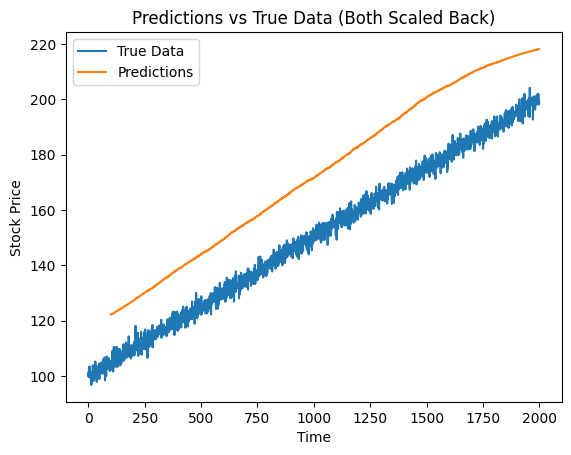

In [ ]:
# Make predictions
predictions = model.predict(X)
predictions = scaler.inverse_transform(predictions)

# Prepare true values for comparison
true_values = scaler.inverse_transform(data.reshape(-1, 1))

# Plot the predictions vs true values
import matplotlib.pyplot as plt

plt.plot(true_values, label='True Data')
plt.plot(np.arange(time_step, time_step + len(predictions)), predictions, label='Predictions')
plt.xlabel('Time')
plt.ylabel('Stock Price')
plt.legend()
plt.title('Predictions vs True Data (Both Scaled Back)')
plt.show()


In the above code:

- The model's predictions are transformed back to the original scale using the inverse transform of the scaler.

- The true data and predictions are plotted to visualize the model's performance.


## Practice Exercises:

### Exercise 1: Add dropout to the Transformer model

**Objective: Understand how to add dropout layers to the Transformer model to prevent overfitting.**

Instructions:

- Add a dropout layer after the Flatten layer in the model.

- Set the dropout rate to 0.5.


In [ ]:
from tensorflow.keras.layers import Dropout

# Add a dropout layer after the Flatten layer
flatten = tf.keras.layers.Flatten()(encoder_outputs)
dropout = Dropout(0.5)(flatten)
outputs = tf.keras.layers.Dense(1)(dropout)

# Build the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, Y, epochs=20, batch_size=32)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss: {loss}')

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 37s 220ms/step - loss: 6.2090
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - loss: 1.4183
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.7889
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.3822
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.1815
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0867
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 19ms/step - loss: 0.0468
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 18ms/step - loss: 0.0346
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0314
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - loss: 0.0292
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0200
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0207
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0183
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0154
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0143
E

<details><summary>Click here to view the solution.</summary>

```
from tensorflow.keras.layers import Dropout



# Add a dropout layer after the Flatten layer

flatten = tf.keras.layers.Flatten()(encoder_outputs)

dropout = Dropout(0.5)(flatten)

outputs = tf.keras.layers.Dense(1)(dropout)



# Build the model

model = tf.keras.Model(inputs, outputs)



# Compile the model

model.compile(optimizer='adam', loss='mse')



# Train the model

model.fit(X, Y, epochs=20, batch_size=32)



# Evaluate the model

loss = model.evaluate(X, Y)

print(f'Test loss: {loss}')

```

</details>


### Exercise 2: Experiment with different batch sizes

**Objective: Observe the impact of different batch sizes on model performance.**

Instructions:

- Train the model with a batch size of 16.

- Train the model with a batch size of 64.

- Compare the training time and performance.


In [ ]:
# Train the model with batch size 16
model.fit(X, Y, epochs=20, batch_size=16)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 16: {loss}')

# Train the model with batch size 64
model.fit(X, Y, epochs=20, batch_size=64)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 64: {loss}')

Epoch 1/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0180
Epoch 2/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 0.0232
Epoch 3/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0454
Epoch 4/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0245
Epoch 5/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0215
Epoch 6/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0301
Epoch 7/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0231
Epoch 8/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0247
Epoch 9/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0179
Epoch 10/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0207
Epoch 11/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0284
Epoch 12/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0186
Epoch 13/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0154
Epoch 14/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0218
Epoch 15/20
119/119 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/s

<details><summary>Click here to view the solution.</summary>

```
# Train the model with batch size 16
model.fit(X, Y, epochs=20, batch_size=16)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 16: {loss}')

# Train the model with batch size 64
model.fit(X, Y, epochs=20, batch_size=64)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with batch size 64: {loss}')

```

</details>


### Exercise 3: Use a different activation function

**Objective: Understand how different activation functions impact the model performance.**

Instructions:

- Change the activation function of the Dense layer to `tanh`.

- Train and evaluate the model.


In [ ]:
# Change the activation function of the Dense layer to tanh
outputs = tf.keras.layers.Dense(1, activation='tanh')(flatten)

# Build the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, Y, epochs=20, batch_size=32)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with tanh activation: {loss}')

Epoch 1/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 29s 161ms/step - loss: 0.2191
Epoch 2/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - loss: 0.0287
Epoch 3/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0147
Epoch 4/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0063
Epoch 5/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0078
Epoch 6/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0044
Epoch 7/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0029
Epoch 8/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0037
Epoch 9/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0030
Epoch 10/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0046
Epoch 11/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0035
Epoch 12/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0025
Epoch 13/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0032
Epoch 14/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0029
Epoch 15/20
60/60 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.0047
Ep

<details><summary>Click here to view the solution.</summary>

```
# Change the activation function of the Dense layer to tanh
outputs = tf.keras.layers.Dense(1, activation='tanh')(flatten)

# Build the model
model = tf.keras.Model(inputs, outputs)

# Compile the model
model.compile(optimizer='adam', loss='mse')

# Train the model
model.fit(X, Y, epochs=20, batch_size=32)

# Evaluate the model
loss = model.evaluate(X, Y)
print(f'Test loss with tanh activation: {loss}')

```

</details>


## Conclusion

Congratulations on completing this lab! In this lab, you have built an advanced Transformer model using Keras and applied it to a time series forecasting task. You have learned how to define and implement multi-head self-attention, Transformer blocks, encoder layers, and integrate them into a complete Transformer model. By experimenting with different configurations and training the model, you can further improve its performance and apply it to various sequential data tasks.


Copyright © IBM Corporation. All rights reserved.
